# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI
The file is a **transactional database**. Each transaction is represented by several lines (one for each item in the transaction) characterised by the same `InvoiceNo`. In order to discover the association rules we will generate a new file, we will call it `basket` with one row for each transaction and one column for each item of the entire dataset. The content of the row will be 1 for each column corresponding to an item contained in the transaction, 0 for the other columns.

In order to obtain this final representation we will need some **cleaning** operation, simply filtering the input rows and doing some data transformation, then a **grouping** operation to generte the new data structure, with the _Pandas_ functions `groupby` and `unstack`

In [1]:
# this installs a new library in your computer, execute this only the first time, then comment it
# ! pip install mlxtend

In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules

Upload the file `'Online-Retail-France.xlsx'`. It is a MS Excel file, you can read it with the Pandas' function `read_excel`.

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

Insert a cell below with your code

Load the data and show the shape

In [3]:
# insert your code here
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
url = 'Online-Retail-France.xlsx'


There are 8557 rows and 7 columns


Show the head of the file

In [4]:
# insert your code here


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0


Show the data types with `.info()`

In [5]:
# insert your code here


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8557 entries, 0 to 8556
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    8556 non-null   object 
 1   StockCode    8557 non-null   object 
 2   Description  8557 non-null   object 
 3   Quantity     8557 non-null   int64  
 4   InvoiceDate  8557 non-null   object 
 5   UnitPrice    8557 non-null   float64
 6   CustomerID   8491 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 468.1+ KB


Show the number of unique values in `Description`

In [6]:
# insert your code here


The number of unique Description values in the input file is 1565


Some values of `Description` have spurious blanks that generate _false different values_. 

Strip blank spaces fron `Description` with `str.strip()`

In [7]:
# insert your code here


Show the new number of unique values after this cleaning

In [8]:
# insert your code here


After cleaning, the number of unique Description values in the input file is 1564


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. 

In [9]:
# insert your code here


Rows with missing InvoiceNo before removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
15,NaN,21913,VINTAGE SEASIDE JIGSAW PUZZLES,12,2010-12-01 08:45:00,3.75,12583.0


Drop such rows and check if the operation succeeded

In [10]:
# insert your code here


Rows with missing InvoiceNo after removing: 0


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them. 
At the moment the column `InvoiceNo` is a generic object, in order to be 
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [11]:
# insert your code here


There are 149 rows containing 'C' in 'InvoiceNo'


In [13]:
# insert your code here


After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [14]:
# insert your code here


There are 300 rows containing POSTAGE in Description


In [15]:
# insert your code here


After cleaning there are 0 rows containing POSTAGE in Description


Now show a description of the cleaned data file

In [16]:
# insert your code here


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
count,8107,8107,8107,8107.000000,8107,8107.00000,8041.000000
unique,387,1541,1562,NaN,388,NaN,NaN
top,570672,23084,RABBIT NIGHT LIGHT,NaN,2011-10-11 14:52:00,NaN,NaN
freq,259,74,74,NaN,259,NaN,NaN
mean,NaN,NaN,NaN,13.724806,NaN,3.83965,12679.910583
std,NaN,NaN,NaN,21.354558,NaN,66.58728,281.252392
min,NaN,NaN,NaN,1.000000,NaN,0.00000,12413.000000
25%,NaN,NaN,NaN,6.000000,NaN,1.00000,12571.000000
50%,NaN,NaN,NaN,10.000000,NaN,1.65000,12674.000000
75%,NaN,NaN,NaN,12.000000,NaN,2.95000,12689.000000


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, we are only looking at sales for France. However, in additional code below, we will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

Actions:
1. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
1. use the `unstack` function to move the items from rows to columns
1. reset the index
1. fill the missing with zero (`fillna(0)`)
1. store the result in the new dataframe `basket` and inspect it

In [17]:
# insert your code here


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# insert your code here


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,...,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.868217,0.310078,0.005168,0.062016,0.509044,0.385013,0.400517,0.062016,0.281654,0.186047,...,0.193798,0.023256,0.010336,0.002584,0.082687,0.279070,0.012920,0.186047,0.031008,0.062016
std,5.109242,2.474110,0.101666,0.861544,5.445138,2.978173,3.454711,1.219989,2.006660,1.484466,...,2.195417,0.340644,0.203331,0.050833,1.626651,2.348994,0.254164,1.922464,0.609994,0.861544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.000000,20.000000,2.000000,12.000000,96.000000,24.000000,48.000000,24.000000,24.000000,12.000000,...,25.000000,6.000000,4.000000,1.000000,32.000000,36.000000,5.000000,24.000000,12.000000,12.000000


The matrix have zeros and positive values. 

For the association rules we need to keep trace only of presence and absence of an item in a transaction, therefore we will transform `0` to `False` and positive values to `True`

We can define a function `encode_units` which takes a number and returns `False` if the number is 0 or less, `True` if the number is 1 or more. The function can be applied to `basket` with the Pandas' function `map`, the result is stored in the variable `basket_sets`

Inspect the structure and the correctness of the result

This step will complete the _one hot encoding_ of the data.

In [19]:
# insert your code here


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
count,387,387,387,387,387,387,387,387,387,387,...,387,387,387,387,387,387,387,387,387,387
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,375,381,386,385,381,380,380,386,378,381,...,384,385,386,386,386,380,386,383,386,385


Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples):

- generate the `frequent_itemsets` with `apriori`, setting `min_support=0.07` and `use_colnames=True`
- generate the `rules` with `association_rules` using `metric="lift"` and `min_threshold=1`
- show the rules

A more complete version of the exercise would need to repeat the generation with a decreasing value of `min_support` until the desired number of rules is generated.

In [20]:
# insert your code here


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817,0.958700
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305,0.964225
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561,0.978926
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964,0.959901


In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending confidence and support and plot `'confidence'` and `'support'`.

In [21]:
# insert your code here


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.103359,0.139535,0.100775,0.975000,6.987500,0.086353,34.418605,0.955664
1,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.103359,0.129199,0.100775,0.975000,7.546500,0.087421,34.832041,0.967487
2,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.129199,0.139535,0.124031,0.960000,6.880000,0.106003,21.511628,0.981454
3,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.139535,0.129199,0.124031,0.888889,6.880000,0.106003,7.837209,0.993243
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129


<Axes: title={'center': 'Association Rules'}>

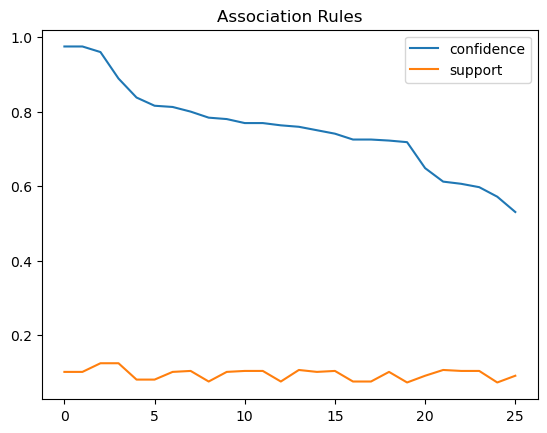

In [22]:
# insert your code here


You find below a three dimensional plot of support and confidence, where the dot size is proportional to the lift, obtained using `plot.scatter`.

You can use the parameter `s` of `scatter` and pass to it the `lift` of the rules. For a more effective display the `lift` should be transformed, for example with `display_lift = 1.8**lift`

<Axes: title={'center': 'Association Rules (dot proportional to Lift)'}, xlabel='support', ylabel='confidence'>

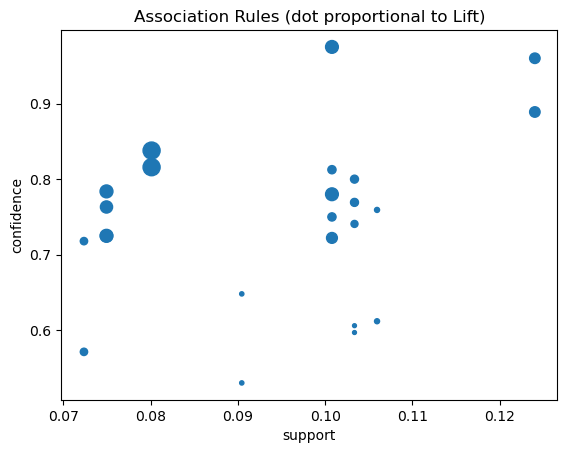

In [23]:
# insert your code here
